In [51]:
import math
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

class WalkingTrot():
    """
  trotting gait
  @author: HonboZhu, BoxiXia
  """
    def __init__(self,
                 phase_offset=0,
                 stance_ratio=0.6,
                 stance_start_angle=math.pi / 4,
                 stance_end_angle=3 * math.pi / 4):
        assert (stance_end_angle > stance_start_angle)
        self.phase_offset = phase_offset
        self.stance_ratio = stance_ratio
        self.stance_start_angle = stance_start_angle
        self.stance_end_angle = stance_end_angle

    def GetPos(self, phase):
        """
    return the position [0,2pi] given the current phase
    """
        contact_angle = self.stance_end_angle - self.stance_start_angle
        speed_air = (2 * math.pi - contact_angle) / (1 - self.stance_ratio)
        speed_contact_ground = contact_angle / self.stance_ratio
        
        phase = phase%1.0
        if (phase < 0):
            phase += 1

        if (phase >= 0 and phase < self.stance_start_angle / speed_air):
            desire_angle = speed_air * phase

        elif (phase >= self.stance_start_angle / speed_air and
              phase < self.stance_start_angle / speed_air + self.stance_ratio):
            desire_angle = self.stance_start_angle + speed_contact_ground * (
                phase - self.stance_start_angle / speed_air)

        else:
            desire_angle = speed_air * phase + 2 * math.pi - speed_air
        return desire_angle

##If moving forward:

In [52]:
trot = WalkingTrot()
phase_arr = np.linspace(0,2,1000)
angle1 = np.array([trot.GetPos(phase) for phase in phase_arr])
angle2 = np.array([trot.GetPos(phase+0.5) for phase in phase_arr])
angle3 = 2*np.pi-angle1
angle4 = 2*np.pi-angle2

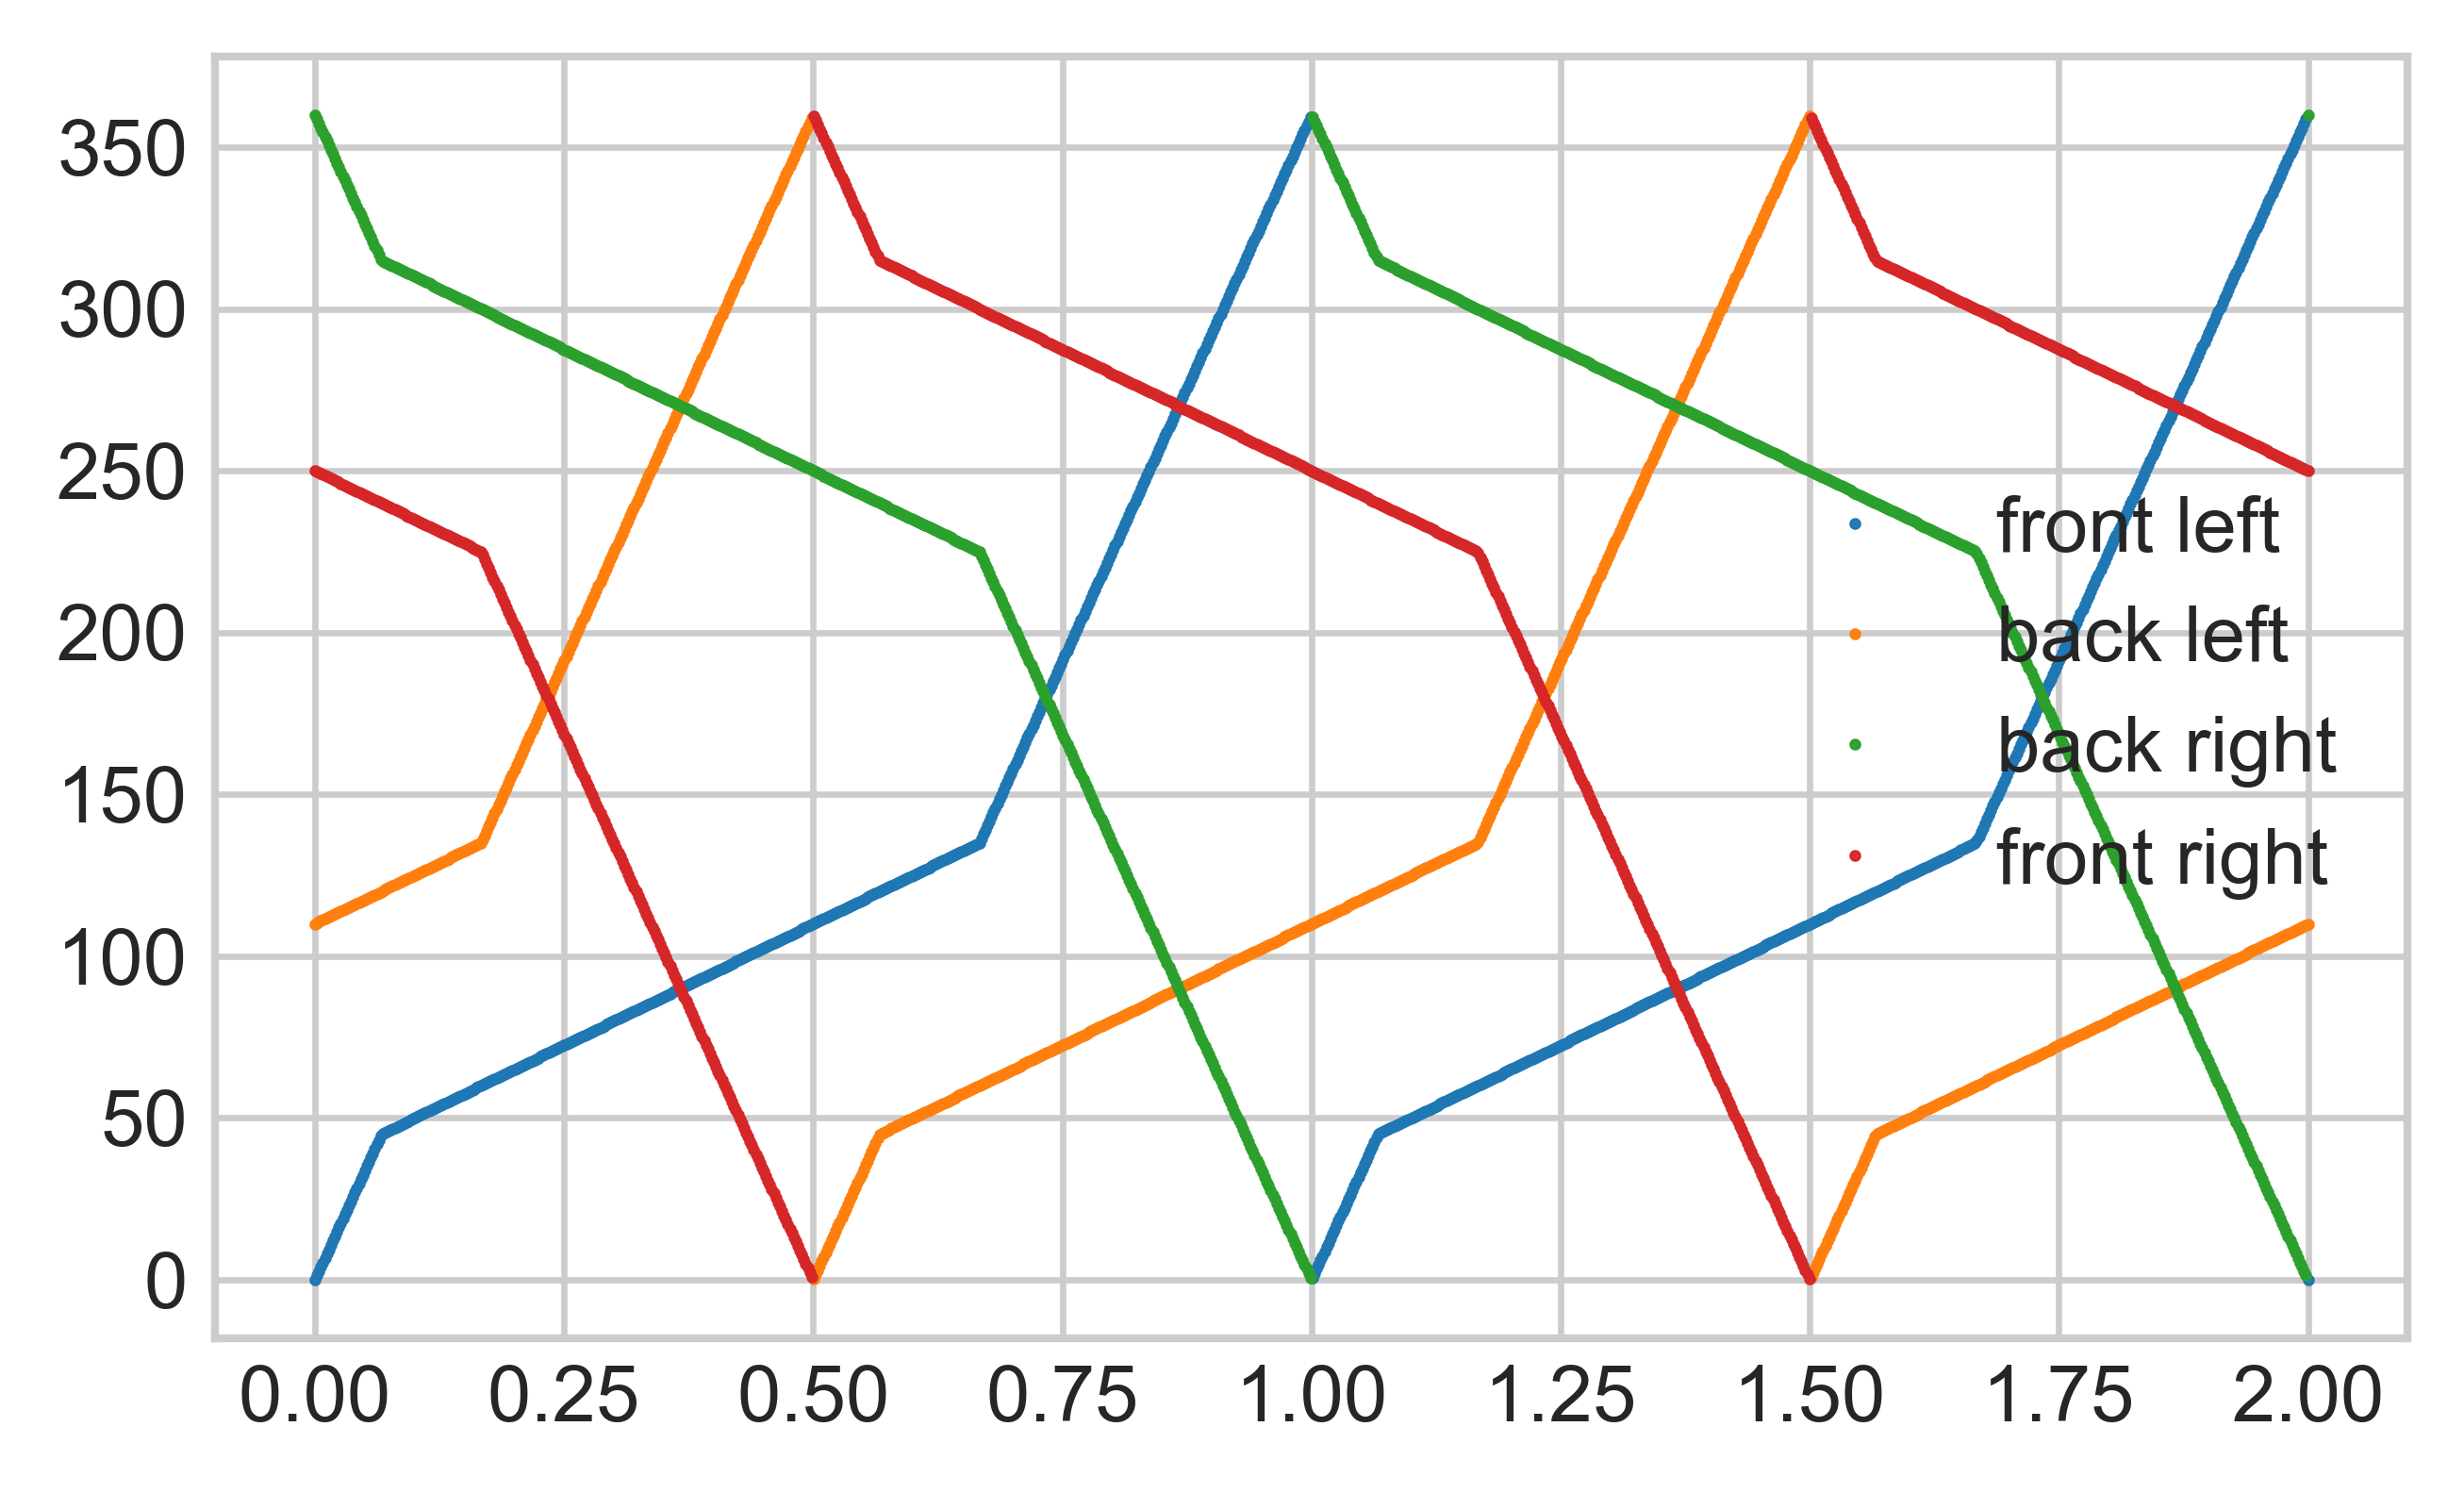

In [53]:
plt.figure(figsize=(5,3),dpi=300)
plt.plot(phase_arr,angle1*180/np.pi,'.',label='front left',markersize=1)
plt.plot(phase_arr,angle2*180/np.pi,'.',label='back left',markersize=1)
plt.plot(phase_arr,angle3*180/np.pi,'.',label='back right',markersize=1)
plt.plot(phase_arr,angle4*180/np.pi,'.',label='front right',markersize=1)
plt.legend()
plt.show()